# Clustering of scikit-learn toy data sets

Go to:

  - [Notebook configuration](scikit_learn_datasets.ipynb#Notebook-configuration)
  - [Data set generation](scikit_learn_datasets.ipynb#Data-set-generation)

  - CommonNN clustering using ...
    - [... point coordinates](scikit_learn_datasets.ipynb#CommonNN-clustering-using-data-point-coordinates-as-input)
    - [... pre-computed distances](scikit_learn_datasets.ipynb#CommonNN-clustering-with-pre-computed-distances)
    - [... pre-computed neighbourhoods](scikit_learn_datasets.ipynb#CommonNN-clustering-with-pre-computed-neighbourhoods)
    - [... pre-computed sorted neighbourhoods](scikit_learn_datasets.ipynb#CommonNN-clustering-with-pre-computed-neighbourhoods-(sorted-by-member-index))
    - [... pre-computed doubly sorted neighbourhoods](scikit_learn_datasets.ipynb#CommonNN-clustering-with-pre-computed-neighbourhoods-(sorted-by-member-index-and-neighbour-count))    
    

## Notebook configuration

In [1]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import datasets
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler

import commonnn
from commonnn import cluster
from commonnn import _types, _fit

In [2]:
# Helper function definitions
def indent_at_parens(s):
    """Take a string and introduce indention at parentheses"""

    o = ""
    level = 1
    saw_comma = False
    for c in s:
        if saw_comma:
            if c == " ":
                o += f"\n{'    ' * (level - 1)}"
            else:
                o += f"\n{'    ' * (level - 1)}{c}"
            saw_comma = False
            continue

        if c == "(":
            o += f"(\n{'    ' * level}"
            level += 1
            continue

        if c == ")":
            level -= 1
            o += f"\n{'    ' * level})"
            continue

        if c == ",":
            saw_comma = True
            o += ","
            continue

        o += c

    return o

Print Python and package version information:

In [3]:
# Version information
print("Python: ", *sys.version.split("\n"))

print("Packages:")
for package in [mpl, np, sklearn, commonnn]:
    print(f"    {package.__name__}: {package.__version__}")

Python:  3.9.0 | packaged by conda-forge | (default, Nov 26 2020, 07:57:39)  [GCC 9.3.0]
Packages:
    matplotlib: 3.9.4
    numpy: 1.26.4
    sklearn: 1.6.1
    commonnn: 0.0.3


We use [Matplotlib](https://matplotlib.org/) to create plots. The `matplotlibrc` file in the root directory of the `CommonNNClustering` repository is used to customize the appearance of the plots.

In [4]:
# Matplotlib configuration
mpl.rc_file(
    "../../matplotlibrc",
    use_default_template=False
)

In [5]:
# Axis property defaults for the plots
ax_props = {
    "xlabel": None,
    "ylabel": None,
    "xlim": (-2.5, 2.5),
    "ylim": (-2.5, 2.5),
    "xticks": (),
    "yticks": (),
    "aspect": "equal"
}

# Line plot property defaults
line_props = {
    "linewidth": 0,
    "marker": '.',
}

## Data set generation

To see the common-nearest-neighbours (CommonNN) clustering in action, let's have a look at a handful of basic 2D data sets from scikit-learn (like here in the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)). We will cluster the data sets starting from different input data formats using the provided defaults. For more details see also the [Advanced usage](advanced_usage.ipynb) tutorial.

In [6]:
# Data set generation parameters
np.random.seed(0)
n_samples = 2000

In [7]:
# Data set generation
# Fit all datasets to the same value range
#    using `data = StandardScaler().fit_transform(data)`

# circles
noisy_circles, _ = datasets.make_circles(
    n_samples=n_samples,
    factor=.5,
    noise=.05
    )
noisy_circles = StandardScaler().fit_transform(noisy_circles)

# moons
noisy_moons, _ = datasets.make_moons(
    n_samples=n_samples,
    noise=.05
    )
noisy_moons = StandardScaler().fit_transform(noisy_moons)

# blobs
blobs, _ = datasets.make_blobs(
    n_samples=n_samples,
    random_state=8
    )
blobs = StandardScaler().fit_transform(blobs)

# None
no_structure = np.random.rand(
    n_samples, 2
    )
no_structure = StandardScaler().fit_transform(no_structure)

# aniso
random_state = 170
X, y = datasets.make_blobs(
    n_samples=n_samples,
    random_state=random_state
    )

transformation = [[0.6, -0.6], [-0.4, 0.8]]
aniso = np.dot(X, transformation)
aniso = StandardScaler().fit_transform(aniso)

# varied
varied, _ = datasets.make_blobs(
    n_samples=n_samples,
    cluster_std=[1.0, 2.5, 0.5],
    random_state=random_state
    )
varied = StandardScaler().fit_transform(varied)

In [8]:
# Define cluster parameters
dsets = [ # "name", set, **parameters
    ('circles', noisy_circles, {
        'radius_cutoff': 0.5,
        'similarity_cutoff': 20,
        'member_cutoff': 100,
        'max_clusters': None
        }),
    ('moons', noisy_moons, {
        'radius_cutoff': 0.5,
        'similarity_cutoff': 20,
        'member_cutoff': 2,
        'max_clusters': None
        }),
    ('varied', varied, {
        'radius_cutoff': 0.28,
        'similarity_cutoff': 20,
        'member_cutoff': 20,
        'max_clusters': None
        }),
    ('aniso', aniso, {
        'radius_cutoff': 0.29,
        'similarity_cutoff': 30,
        'member_cutoff': 5,
        'max_clusters': None
         }),
    ('blobs', blobs, {
        'radius_cutoff': 0.4,
        'similarity_cutoff': 20,
        'member_cutoff': 2,
        'max_clusters': None
        }),
    ('None', no_structure, {
        'radius_cutoff': 0.5,
        'similarity_cutoff': 20,
        'member_cutoff': 1,
        'max_clusters': None
        }),
    ]

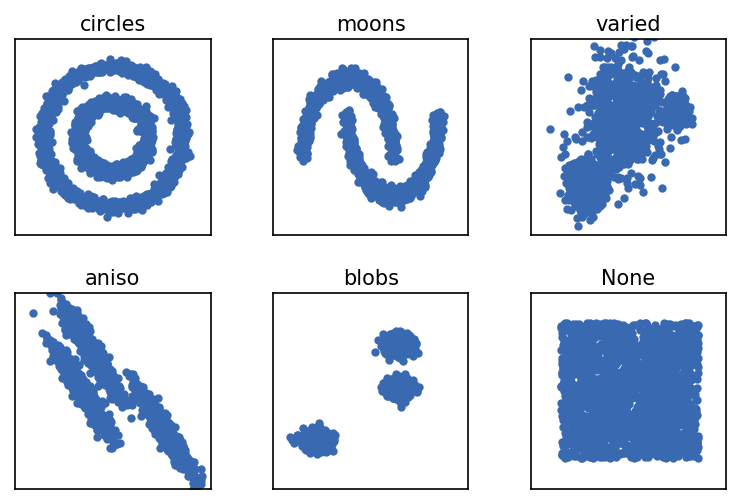

In [9]:
# Plot the original data sets
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, *_) in enumerate(dsets):    
    Ax[count].plot(data[:, 0], data[:, 1], **line_props)
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

## CommonNN clustering using data point coordinates as input

-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
2000      0.500     20        100       None      2         0.500     0.000     00:00:0.086
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
2000      0.500     20        2         None      2         0.500     0.000     00:00:0.094
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
2000      0.280     20        20        None      3         0.

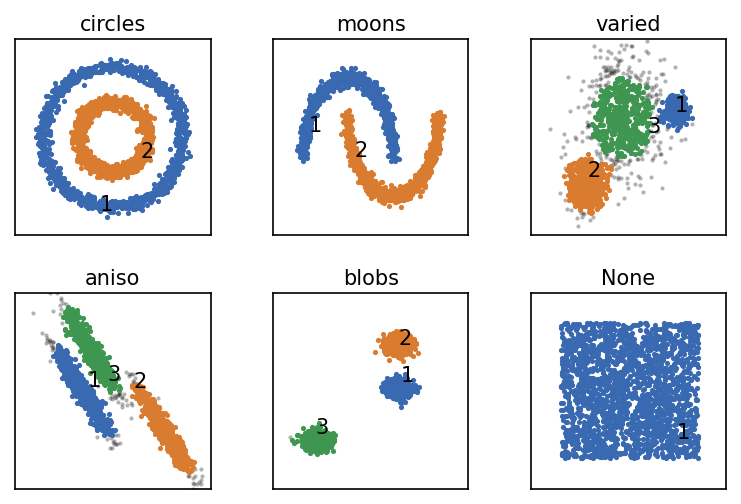

In [10]:
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, params) in enumerate(dsets):

    # Default clustering initialisation
    clustering = cluster.Clustering(data)

    # Calculate neighbours brute force
    clustering.fit(**params)
    print()

    clustering.evaluate(ax=Ax[count], annotate_pos="random")
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

When *raw* input data is presented to a `Clustering` on creation without specifying anything else, the obtained `Clustering` object aggregates the needed clustering components, assuming that it got point coordinates as a sequence of sequences. The neighbourhood of a specific point will be collected brute-force by computing the (Euclidean) distances to all other points and comparing them to the radius cutoff. This will be the slowest possible approach but it has fairly conservative memory usage.

In [11]:
# Clustering components used by default ("coordinates" recipe)
print(indent_at_parens(str(clustering)))

Clustering(
    input_data=InputDataExtComponentsMemoryview(
        components of 2000 points in 2 dimensions
        ),
    fitter=FitterExtCommonNNBFS(
        ngetter=NeighboursGetterExtBruteForce(
            dgetter=DistanceGetterExtMetric(
                metric=MetricExtEuclideanReduced
                ),
            sorted=False,
            selfcounting=True
            ),
        na=NeighboursExtVectorUnorderedSet,
        nb=NeighboursExtVectorUnorderedSet,
        checker=SimilarityCheckerExtSwitchContains,
        queue=QueueExtFIFOQueue
        ),
    hierarchical_fitter=None,
    predictor=None
    )


## CommonNN clustering with pre-computed distances

-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
2000      0.500     20        100       None      2         0.500     0.000     00:00:0.116
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
2000      0.500     20        2         None      2         0.500     0.000     00:00:0.105
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
2000      0.280     20        20        None      3         0.

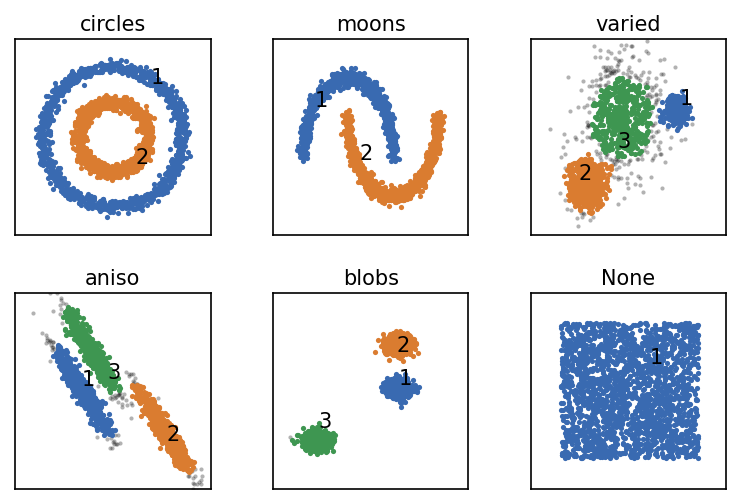

In [12]:
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, params) in enumerate(dsets):
    
    # Default clustering initialisation
    clustering = cluster.Clustering(data)  
    
    # Pre-compute distances and choose the corresponding recipe 
    distances = pairwise_distances(data)
    clustering_dist = cluster.Clustering(
        distances,
        recipe="distances"
        )   
    
    # Use pre-computed distances
    clustering_dist.fit(**params)
    clustering.labels = clustering_dist.labels
    print()

    clustering.evaluate(ax=Ax[count], annotate_pos="random")
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

When *raw* input data is presented to a `Clustering` on creation in terms of a dense distance matrix, the "distances" recipe can be chosen to make the obtained `Clustering` object aggregate the needed clustering components. The neighbourhood of a specific point will be collected brute-force by looking up distances from the input data. This will be somewhat faster as no distances need to be calculated during the clustering but it has a high memory demand. It also allows to leverage smart external methods for the task of the distance calculation.

In [13]:
# Clustering components used by the "distance" recipe
print(indent_at_parens(str(clustering_dist)))

Clustering(
    input_data=InputDataExtComponentsMemoryview(
        components of 2000 points in 2000 dimensions
        ),
    fitter=FitterExtCommonNNBFS(
        ngetter=NeighboursGetterExtBruteForce(
            dgetter=DistanceGetterExtMetric(
                metric=MetricExtPrecomputed
                ),
            sorted=False,
            selfcounting=True
            ),
        na=NeighboursExtVectorUnorderedSet,
        nb=NeighboursExtVectorUnorderedSet,
        checker=SimilarityCheckerExtSwitchContains,
        queue=QueueExtFIFOQueue
        ),
    hierarchical_fitter=None,
    predictor=None
    )


## CommonNN clustering with pre-computed neighbourhoods

-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
2000      0.500     20        100       None      2         0.500     0.000     00:00:0.015
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
2000      0.500     20        2         None      2         0.500     0.000     00:00:0.021
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
2000      0.280     20        20        None      3         0.

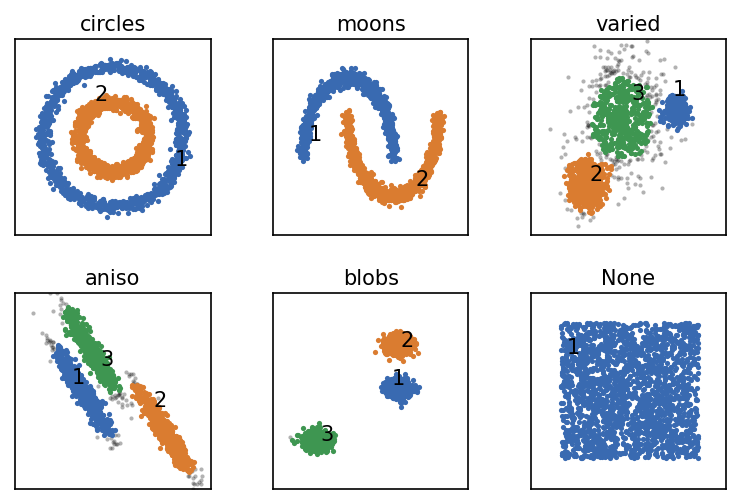

In [14]:
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, params) in enumerate(dsets):
    
    clustering = cluster.Clustering(data)  
    
    # Pre-compute neighbourhoods and choose the corresponding recipe
    tree = KDTree(data)
    neighbourhoods = tree.query_radius(
        data, r=params["radius_cutoff"], return_distance=False
        )
    
    clustering_neighbourhoods = cluster.Clustering(
        neighbourhoods,
        recipe="neighbourhoods"
        )
    
    # Use pre-computed neighbourhoods
    clustering_neighbourhoods.fit(**params)
    clustering.labels = clustering_neighbourhoods.labels
    print()

    clustering.evaluate(ax=Ax[count], annotate_pos="random")
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

When *raw* input data is presented to a `Clustering` on creation in terms of pre-computed neighbourhoods, the "neighbourhoods" recipe can be chosen to make the obtained `Clustering` object aggregate the needed clustering components. The neighbourhood of a specific point will looked up from the input data. This will be considerably faster and it has a lower memory demand compared to the "distances" case. It also allows to leverage smart external methods for the task of the neighbourhood calculation.

Note, that the "neighbourhoods" recipe requires the *raw* neighbourhoods in the concrete format of a matrix in which the neighbourhoods of individual points are padded to the length of the largest neighbourhood. If neighbourhoods are presented in terms of a sequence of sequences (with varying length) as one would get from a tree query to `sklearn.neighbors.KDTree`, this can be transformed into the suitable format using the preparation hook `hooks.prepare_neighbourhoods`.

In [15]:
# Clustering components used by the "distance" recipe
print(indent_at_parens(str(clustering_neighbourhoods)))

Clustering(
    input_data=InputDataExtNeighbourhoodsMemoryview(
        neighbourhoods of 2000 points
        ),
    fitter=FitterExtCommonNNBFS(
        ngetter=NeighboursGetterExtLookup(
            sorted=False,
            selfcounting=True
            ),
        na=NeighboursExtVectorUnorderedSet,
        nb=NeighboursExtVectorUnorderedSet,
        checker=SimilarityCheckerExtSwitchContains,
        queue=QueueExtFIFOQueue
        ),
    hierarchical_fitter=None,
    predictor=None
    )


## CommonNN clustering with pre-computed neighbourhoods (sorted by member index)

-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
2000      0.500     20        100       None      2         0.500     0.000     00:00:0.003
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
2000      0.500     20        2         None      2         0.500     0.000     00:00:0.003
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
2000      0.280     20        20        None      3         0.

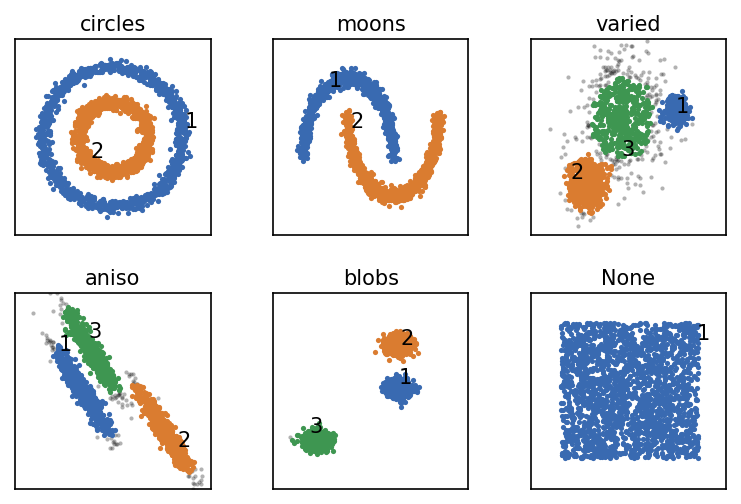

In [16]:
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, params) in enumerate(dsets):

    clustering = cluster.Clustering(data)  
    
    # Pre-compute and sort neighbourhoods and choose the corresponding recipe
    tree = KDTree(data)
    neighbourhoods = tree.query_radius(
        data, r=params["radius_cutoff"], return_distance=False
        )

    for n in neighbourhoods:
        n.sort()

    # Custom initialisation using a clustering builder
    clustering_neighbourhoods_sorted = cluster.Clustering(
        neighbourhoods,
        recipe="sorted_neighbourhoods"
        )
    
    # Use pre-computed neighbourhoods
    clustering_neighbourhoods_sorted.fit(**params)
    clustering.labels = clustering_neighbourhoods_sorted.labels
    print()

    clustering.evaluate(ax=Ax[count], annotate_pos="random")
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

Pre-computed neighbourhood information can be additionally sorted in terms of the indices of the members (i.e. so that within each neighbourhood the members are stored in increasing order of there index in the data set). While this has the same memory demand as using unsorted neighbourhoods, it offers the fastest clustering. 

In [17]:
# Clustering components used by the "distance" recipe
print(indent_at_parens(str(clustering_neighbourhoods_sorted)))

Clustering(
    input_data=InputDataExtNeighbourhoodsMemoryview(
        neighbourhoods of 2000 points
        ),
    fitter=FitterExtCommonNNBFS(
        ngetter=NeighboursGetterExtLookup(
            sorted=True,
            selfcounting=True
            ),
        na=NeighboursExtVector,
        nb=NeighboursExtVector,
        checker=SimilarityCheckerExtScreensorted,
        queue=QueueExtFIFOQueue
        ),
    hierarchical_fitter=None,
    predictor=None
    )



## CommonNN clustering with pre-computed neighbourhoods (sorted by member index and neighbour count)

-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
2000      0.500     20        100       None      2         0.500     0.000     00:00:0.002
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
2000      0.500     20        2         None      2         0.500     0.000     00:00:0.003
-----------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------------------
#points   r         nc        min       max       #clusters %largest  %noise    time     
2000      0.280     20        20        None      3         0.

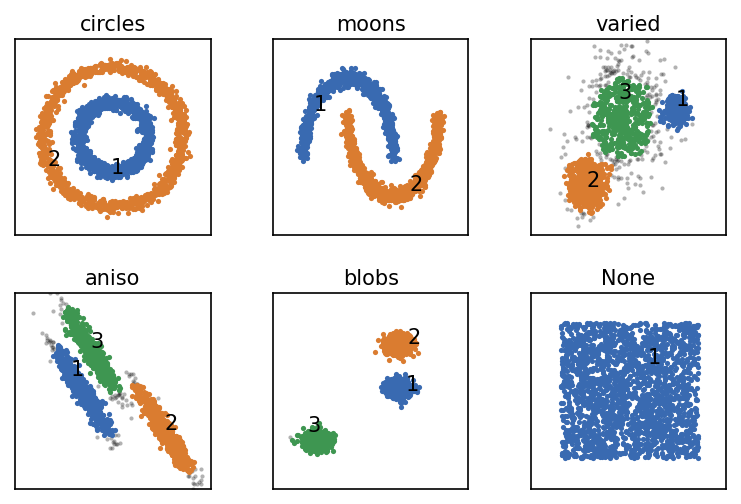

In [19]:
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, params) in enumerate(dsets):

    clustering = cluster.Clustering(data)  
    
    # Pre-compute and sort neighbourhoods and choose the corresponding recipe
    tree = KDTree(data)
    neighbourhoods = tree.query_radius(
        data, r=params["radius_cutoff"], return_distance=False
        )
      
    n_members = np.array([
        n.shape[0]
        for n in neighbourhoods
    ])
    sorted_by_member_count = np.argsort(n_members)[::-1]
    revert_sort = np.argsort(sorted_by_member_count)
    neighbourhoods = neighbourhoods[sorted_by_member_count]
    neighbourhoods = [revert_sort[n] for n in neighbourhoods]

    for n in neighbourhoods:
        n.sort()
       
    # Custom initialisation using a clustering builder
    clustering_neighbourhoods_sorted = cluster.Clustering(
        neighbourhoods,
        recipe="sorted_neighbourhoods"
        )
    
    # Use pre-computed neighbourhoods
    clustering_neighbourhoods_sorted.fit(**params)
    clustering.labels = clustering_neighbourhoods_sorted.labels[revert_sort]
    print()

    clustering.evaluate(ax=Ax[count], annotate_pos="random")
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

As a further addition to the sorting of each neighbourhood by member indices, it is possible to sort all neighbourhoods according to their member count (i.e. so that the point with the highest neighbour count becomes the first point in the data set). It is not guaranteed but this additional sorting can make the clustering even more efficient. 

In [20]:
# Clustering components used by the "distance" recipe
print(indent_at_parens(str(clustering_neighbourhoods_sorted)))

Clustering(
    input_data=InputDataExtNeighbourhoodsMemoryview(
        neighbourhoods of 2000 points
        ),
    fitter=FitterExtCommonNNBFS(
        ngetter=NeighboursGetterExtLookup(
            sorted=True,
            selfcounting=True
            ),
        na=NeighboursExtVector,
        nb=NeighboursExtVector,
        checker=SimilarityCheckerExtScreensorted,
        queue=QueueExtFIFOQueue
        ),
    hierarchical_fitter=None,
    predictor=None
    )
